# Linear Regression

A simple linear regression model to serve as a benchmark against which the performance of other techniques can be compared. This model will not be optimised.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/hourly-weather-wind_direction.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(5000, 36)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,180.0,190.0,150.0,190.0,260.0,310.0,60.0,170.0,320.0,140.0,230.0,210.0,170.0,130.0,30.0,170.0,10.0,140.0,220.0,164.0,30.0,80.0,191.0,80.0,250.0,20.0,230.0,238.0,350.0,220.0,268.0,0.0,342.0,7.0,7.0,0.0
2017-03-25 02:00:00,180.0,210.0,150.0,200.0,270.0,261.0,140.0,160.0,310.0,160.0,220.0,200.0,180.0,120.0,30.0,150.0,30.0,140.0,210.0,140.0,20.0,110.0,173.0,70.0,240.0,350.0,208.0,213.0,340.0,230.0,249.0,0.0,360.0,10.0,10.0,0.0
2017-03-25 03:00:00,250.0,210.0,160.0,190.0,260.0,261.0,150.0,190.0,310.0,87.0,310.0,250.0,180.0,130.0,50.0,150.0,360.0,140.0,210.0,140.0,360.0,110.0,173.0,80.0,230.0,50.0,208.0,213.0,320.0,230.0,249.0,0.0,343.0,10.0,10.0,0.0
2017-03-25 04:00:00,180.0,0.0,160.0,180.0,220.0,290.0,200.0,259.0,310.0,87.0,310.0,290.0,230.0,70.0,50.0,140.0,360.0,140.0,210.0,140.0,30.0,120.0,173.0,50.0,220.0,60.0,208.0,240.0,310.0,230.0,249.0,0.0,10.0,0.0,0.0,0.0
2017-03-25 05:00:00,190.0,220.0,160.0,180.0,270.0,300.0,240.0,256.0,360.0,220.0,320.0,290.0,200.0,50.0,70.0,120.0,360.0,130.0,180.0,160.0,30.0,90.0,180.0,90.0,230.0,20.0,217.0,208.0,240.0,230.0,250.0,0.0,340.0,13.0,13.0,0.0


## Define Parameters

Make predictions for 24-hour period using a training period of four weeks.

In [4]:
dataset_name = 'Hourly Weather Wind Direction'
dataset_abbr = 'HWD'
model_name = 'LinearRegression'
context_length = 24*7*4 # Four weeks
prediction_length = 24

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Example Linear Regression Model

Functions will be used to readily prepare datasets for each time series.

In [6]:
def select_ts(ts, df=df):
    dft = df.iloc[:, ts-1]
    return dft

In [7]:
def create_features(dft, window=prediction_length):
    dftf = dft.copy()
    dftf = dftf.reset_index()
    # One hot encode day of week
    day_names = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
    for i in range(7):
        dftf[day_names[i]] = (dftf['DateTime'].dt.dayofweek == i).astype(int)

    # One hot encode hour of day
    hour_names = ['hour_%s' % str(i) for i in range(24)]
    for i in range(24):
        dftf[hour_names[i]] = (dftf['DateTime'].dt.hour == i).astype(int)

    # Continuous variable for years
    dftf['annual'] = (dftf['DateTime'] - dftf['DateTime'][0]).dt.days / 365

    # Moving average
    dftf['ma'] = dftf.iloc[:, 1].rolling(window).mean()
    dftf['ma'] = dftf['ma'].shift(window)
    dftf.dropna(inplace=True)
    
    dftf.set_index('DateTime', inplace=True)
    
    return dftf

In [8]:
def split_data(dftf, test_length=prediction_length):
    X_train = dftf.iloc[:-test_length, 1:]
    X_test = dftf.iloc[-test_length:, 1:]

    y_train = dftf.iloc[:-test_length, 0]
    y_test = dftf.iloc[-test_length:, 0]
    
    return X_train, X_test, y_train, y_test

Illustrate model for an example household. Ridge regression is used for regularisation.

In [9]:
from sklearn.linear_model import Ridge

ts = 1
df_ex = select_ts(ts)
df_ex = create_features(df_ex)
X_train, X_test, y_train, y_test = split_data(df_ex)

lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred[y_pred < 0] = 0
sMASE = calc_sMASE(y_train[-(context_length + prediction_length):-prediction_length], y_test, y_pred)
print("sMASE: {:.4f}".format(sMASE))

sMASE: 0.8046


Plot example predictions.

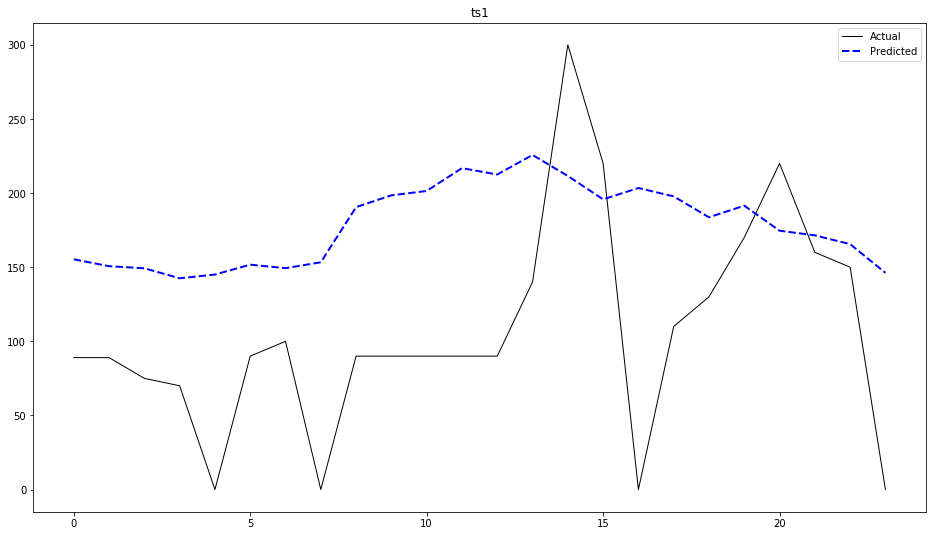

In [10]:
plt.plot(y_test.values, label='Actual', c='k', linewidth=1)
plt.plot(y_pred, label='Predicted', c='b', linestyle='--', linewidth=2)
plt.legend()
plt.title('ts%s' % ts);

Examine example linear regression model coefficients.

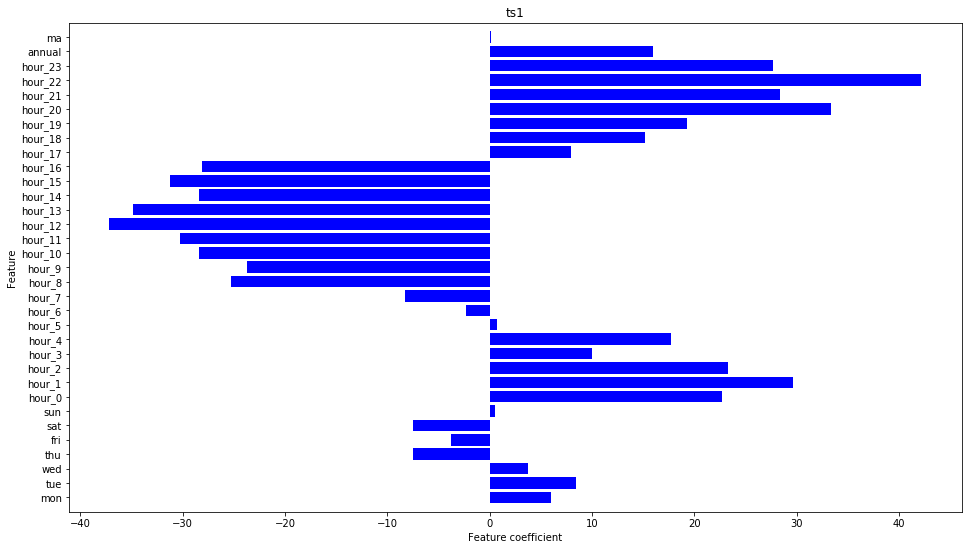

In [11]:
coefs = lr.coef_
cols = df_ex.columns[1:]
params = pd.Series(coefs, index=cols)

fig, ax = plt.subplots()
ax.barh(range(len(params)), params.values, align='center', color='b')
plt.xlabel('Feature coefficient')
plt.yticks(np.arange(len(params)), params.index)
plt.ylabel('Feature')
plt.ylim(-1, len(params))
plt.title('ts%s' % ts);

## Evaluate Linear Regresion

In [12]:
results = df.copy()

for i in range(len(df.columns)):
    ts = i + 1
    dft = select_ts(ts)
    dftf = create_features(dft)
    X_train, X_test, y_train, y_test = split_data(dftf)

    lr = Ridge()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    results['pred%s' % ts] = np.nan
    results['pred%s' % ts].iloc[-prediction_length:] = y_pred

In [13]:
results0 = results.copy()
results0[results0 < 0] = 0

In [14]:
results0.head()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,pred17,pred18,pred19,pred20,pred21,pred22,pred23,pred24,pred25,pred26,pred27,pred28,pred29,pred30,pred31,pred32,pred33,pred34,pred35,pred36
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25 01:00:00,180.0,190.0,150.0,190.0,260.0,310.0,60.0,170.0,320.0,140.0,230.0,210.0,170.0,130.0,30.0,170.0,10.0,140.0,220.0,164.0,30.0,80.0,191.0,80.0,250.0,20.0,230.0,238.0,350.0,220.0,268.0,0.0,342.0,7.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-25 02:00:00,180.0,210.0,150.0,200.0,270.0,261.0,140.0,160.0,310.0,160.0,220.0,200.0,180.0,120.0,30.0,150.0,30.0,140.0,210.0,140.0,20.0,110.0,173.0,70.0,240.0,350.0,208.0,213.0,340.0,230.0,249.0,0.0,360.0,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-25 03:00:00,250.0,210.0,160.0,190.0,260.0,261.0,150.0,190.0,310.0,87.0,310.0,250.0,180.0,130.0,50.0,150.0,360.0,140.0,210.0,140.0,360.0,110.0,173.0,80.0,230.0,50.0,208.0,213.0,320.0,230.0,249.0,0.0,343.0,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-25 04:00:00,180.0,0.0,160.0,180.0,220.0,290.0,200.0,259.0,310.0,87.0,310.0,290.0,230.0,70.0,50.0,140.0,360.0,140.0,210.0,140.0,30.0,120.0,173.0,50.0,220.0,60.0,208.0,240.0,310.0,230.0,249.0,0.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-25 05:00:00,190.0,220.0,160.0,180.0,270.0,300.0,240.0,256.0,360.0,220.0,320.0,290.0,200.0,50.0,70.0,120.0,360.0,130.0,180.0,160.0,30.0,90.0,180.0,90.0,230.0,20.0,217.0,208.0,240.0,230.0,250.0,0.0,340.0,13.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results[col].iloc[-prediction_length:],
                             results['pred%s' % str(i+1)].iloc[-prediction_length:]))

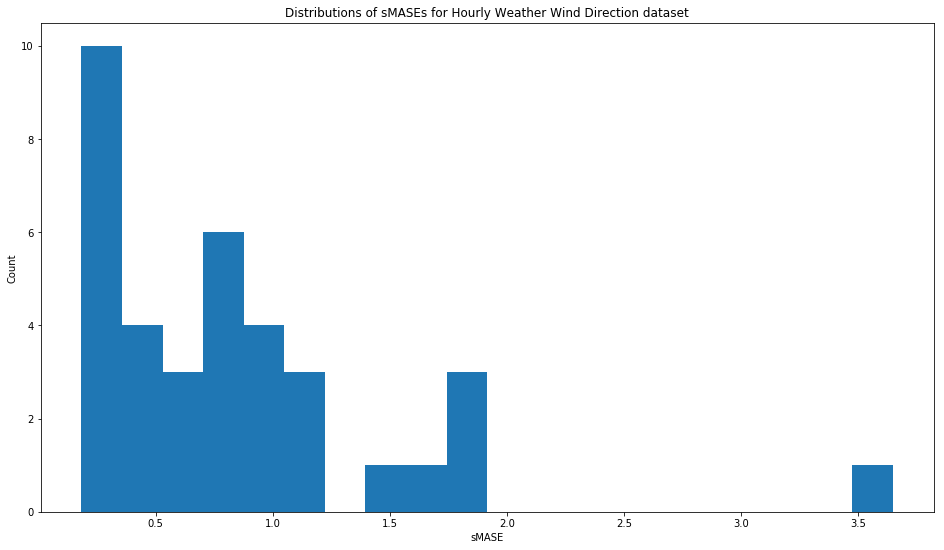

In [16]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [17]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 0.8309


Show some example forecasts.

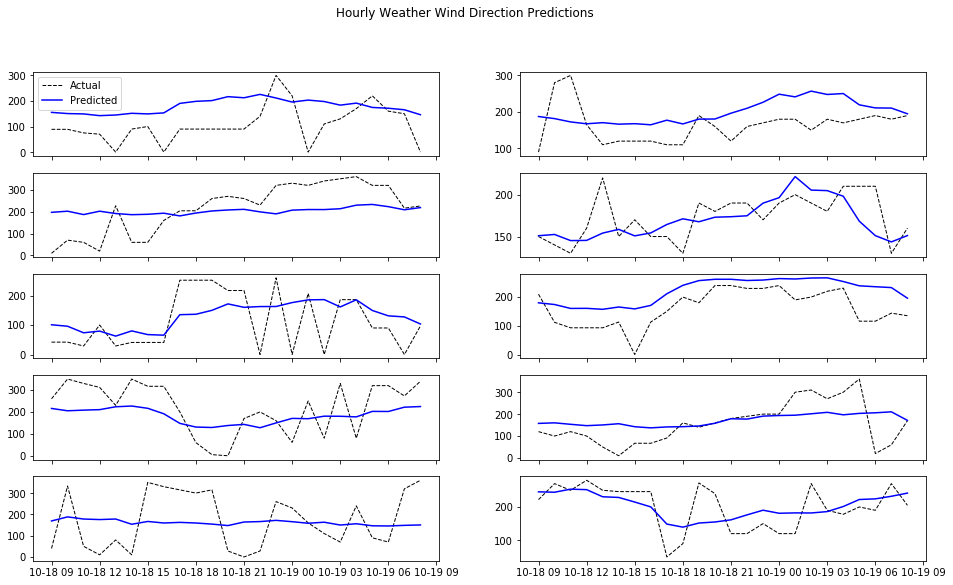

In [18]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results.index[-prediction_length:], results['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results.index[-prediction_length:], results['pred%s' % col].iloc[-prediction_length:],
                   label='Predicted', c='b')
fig.suptitle('{} Predictions'.format(dataset_name))
ax[0].legend();

Store the predictions and accuracy score for the Linear Regression models.

In [19]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)